In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install nltk
!pip install wordcloud
!pip install elasticsearch
!pip install elasticsearch_dsl
!pip install sklearn
!pip install seaborn

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nltk
import re
import string
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from config import Config
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

In [22]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/changp3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/changp3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/changp3/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [23]:
# download tweets and remove NA/irrelevant
tweets1 = pd.read_csv("ukraine1.csv")
tweets2 = pd.read_csv("ukraine2.csv")
tweets3 = pd.read_csv("ukraine3.csv")
tweets_df = pd.concat([tweets1, tweets2, tweets3], axis=0)
tweets_df = tweets_df.dropna()
tweets_df = tweets_df[tweets_df["Stance Label"] != "Irrelevant"]
tweets_df

,id_str,created_at,full_text,Stance Label
5,1497026099494023173,2022-02-25 01:50:10,"Russian Rosgvardia troops, likely spetsnaz, cr...",Neutral
6,1497258644987002880,2022-02-25 17:14:13,@WrestlingWombat @HStefansonMB What is happeni...,ProUkraine
8,1497872993732628484,2022-02-27 09:55:25,Today on the campaign trail I had some tough c...,ProUkraine
10,1499163764951818241,2022-03-02 23:24:29,"ICYMI: n light of Russia sanctions, Fed chair ...",Neutral
11,1499467511087222789,2022-03-03 19:31:28,By now over a thousand refugees from #Ukraine ...,ProUkraine
...,...,...,...,...
1243,1562625045360680963,2022-08-25 02:16:57,National Post: Ukraine: Global reactions six m...,Neutral
1244,1562657696117309440,2022-08-25 04:26:42,@WaitingOnBiden @ChairladySpears I would make ...,Neutral
1248,1562862771829886976,2022-08-25 18:01:36,HOORAY ANOTHER 3 BILLION FOR UKRAINE NAZIS!\nO...,ProRussia
1249,1562884381592522752,2022-08-25 19:27:28,Russia Paying High Price As War Machine Stalls...,Neutral


In [24]:
# print out IDs
ids = list(tweets_df["id_str"])
ids = [str(i) for i in ids]
ids

['1497026099494023173',
 '1497258644987002880',
 '1497872993732628484',
 '1499163764951818241',
 '1499467511087222789',
 '1508139059427819522',
 '1508675556358774786',
 '1512504441324322834',
 '1515578470755192837',
 '1516846493637951489',
 '1517098537628037120',
 '1517453411591102464',
 '1517597388353024001',
 '1517720860991365121',
 '1517849291636813827',
 '1517864226236379137',
 '1517897475293540352',
 '1517905212727603206',
 '1517930292308176896',
 '1517938800634257410',
 '1517940591132356611',
 '1517978964970688515',
 '1517990353630121985',
 '1518007345607020546',
 '1518011431119036417',
 '1518055868532731904',
 '1518205474486824961',
 '1518218763669286912',
 '1518317988352516096',
 '1518355767287599106',
 '1518505279473790977',
 '1518628246069387272',
 '1518635918478950402',
 '1518679968246648832',
 '1518815496493146112',
 '1518945045587578882',
 '1518965658956046336',
 '1519008064136830977',
 '1519011218782101505',
 '1519140873937645569',
 '1519198734885826563',
 '15191988640367

In [25]:
# query elastic search
config = Config.load("config.json")
es = Elasticsearch(hosts=[config.elasticsearch_host], verify_certs=config.elasticsearch_verify_certs, timeout=config.elasticsearch_timeout_secs)

s = Search(using=es, index="ukraine-data-lite-oct22")
s = s.params(size=config.elasticsearch_batch_size)
s.update_from_dict({"query": {"terms": {"id_str": ids}}})
hits = s.execute()

In [26]:
# Calculate sentiment -> add it to dataframe, then also add BERT sentence embeddings
data = []
for hit in hits:
    hd = hit.to_dict()
    # row = [str(hd["id_str"]), hd["sentiment"]["vader"]["primary"], hd["sentiment"]["roberta"]["primary"]]
    
    row = [str(hd["id_str"])]
    if hd["sentiment"]["vader"]["primary"] >= 0.05:
        row.append("Positive")
    elif hd["sentiment"]["vader"]["primary"] <= -0.05:
        row.append("Negative")
    else:
        row.append("Neutral")
        
    for e in hd["embedding"]["sbert"]["primary"]:
        row.append(e)
    data.append(row)
# cols=["id_str", "vader", "roberta"]
cols=["id_str", "sentiment"]
for i in range(384):
    cols.append("e" + str(i))
hits_df = pd.DataFrame(data, columns=cols)
hits_df["id_str"] = pd.to_numeric(hits_df["id_str"])
tweets_df_emb = pd.merge(tweets_df, hits_df, left_on="id_str", right_on="id_str", how="left")
tweets_df_emb

,id_str,created_at,full_text,Stance Label,sentiment,e0,e1,e2,e3,e4,...,e374,e375,e376,e377,e378,e379,e380,e381,e382,e383
0,1497026099494023173,2022-02-25 01:50:10,"Russian Rosgvardia troops, likely spetsnaz, cr...",Neutral,Neutral,-0.016428,-0.030867,-0.108452,0.028263,0.075212,...,-0.049933,-0.035508,0.036970,0.060009,0.066801,-0.036655,-0.086923,0.105668,-0.016366,-0.069354
1,1497258644987002880,2022-02-25 17:14:13,@WrestlingWombat @HStefansonMB What is happeni...,ProUkraine,Positive,-0.010908,0.031075,-0.058351,-0.025464,0.103008,...,0.088302,0.007218,0.062092,0.061128,-0.005803,0.011517,-0.061108,-0.029566,0.007032,-0.003452
2,1497872993732628484,2022-02-27 09:55:25,Today on the campaign trail I had some tough c...,ProUkraine,Positive,0.004661,0.056667,-0.006499,-0.022821,0.148745,...,-0.002751,0.035645,-0.008943,0.020230,-0.016765,0.041365,-0.057042,-0.024530,-0.084994,-0.009728
3,1499163764951818241,2022-03-02 23:24:29,"ICYMI: n light of Russia sanctions, Fed chair ...",Neutral,Negative,-0.035487,-0.015148,-0.022258,-0.037107,0.063298,...,0.097122,-0.011703,0.025038,0.022059,-0.030170,-0.031461,-0.063298,-0.018575,0.081156,-0.075513
4,1499467511087222789,2022-03-03 19:31:28,By now over a thousand refugees from #Ukraine ...,ProUkraine,Positive,0.004067,0.036829,0.016945,-0.000131,-0.011076,...,0.019455,-0.044838,0.039540,0.012494,0.067604,0.038665,-0.019220,0.092685,0.064685,0.075124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732,1562625045360680963,2022-08-25 02:16:57,National Post: Ukraine: Global reactions six m...,Neutral,Neutral,-0.006770,-0.019700,-0.033797,0.010974,0.010369,...,0.065496,-0.002759,0.006895,-0.006750,0.032202,0.034048,-0.090800,0.017218,0.006770,-0.009593
1733,1562657696117309440,2022-08-25 04:26:42,@WaitingOnBiden @ChairladySpears I would make ...,Neutral,Negative,-0.016709,-0.013720,0.007968,0.004380,-0.003577,...,0.100071,-0.015722,-0.000610,0.046376,-0.029843,0.060490,-0.124133,-0.034849,0.008387,-0.018286
1734,1562862771829886976,2022-08-25 18:01:36,HOORAY ANOTHER 3 BILLION FOR UKRAINE NAZIS!\nO...,ProRussia,Positive,0.007825,0.033823,-0.041884,0.008597,0.039415,...,0.079051,-0.077905,0.005565,-0.054000,0.028081,0.021639,-0.016862,-0.019519,0.026918,0.024868
1735,1562884381592522752,2022-08-25 19:27:28,Russia Paying High Price As War Machine Stalls...,Neutral,Negative,-0.012501,-0.021891,-0.036911,-0.005968,-0.021160,...,-0.031993,-0.049490,0.041904,0.057852,-0.018870,0.038522,-0.055789,-0.100014,0.027746,-0.032946


   ProUkraine  ProRussia  Neutral
0         808        353      576


Text(0.5, 1.0, "Distribution of the Collected Tweet's Stance on the Crisis\n(n=1737)")

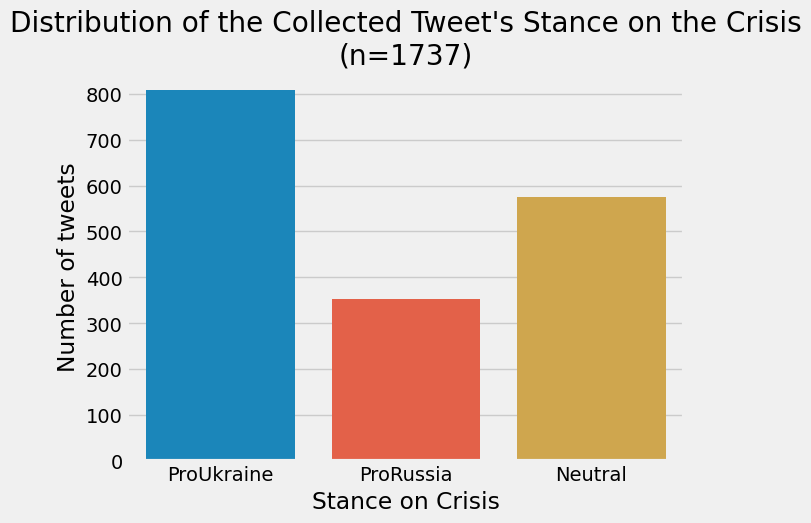

In [27]:
# Stance barplot
pos = ["ProUkraine", "ProRussia", "Neutral"]
cs = {}
# sns.barplot(data=)
for p in pos:
    cs[p] = [np.sum(tweets_df_emb["Stance Label"] == p)]
cum_sums = pd.DataFrame(cs)
sns.barplot(data=cum_sums)
print(cum_sums)
plt.xlabel("Stance on Crisis")
plt.ylabel("Number of tweets")
plt.title("Distribution of the Collected Tweet's Stance on the Crisis\n(n=1737)")

   Positive  Negative  Neutral
0       561       876      300


Text(0.5, 1.0, 'VADER Sentiment of the Tweets\n(n=1737)')

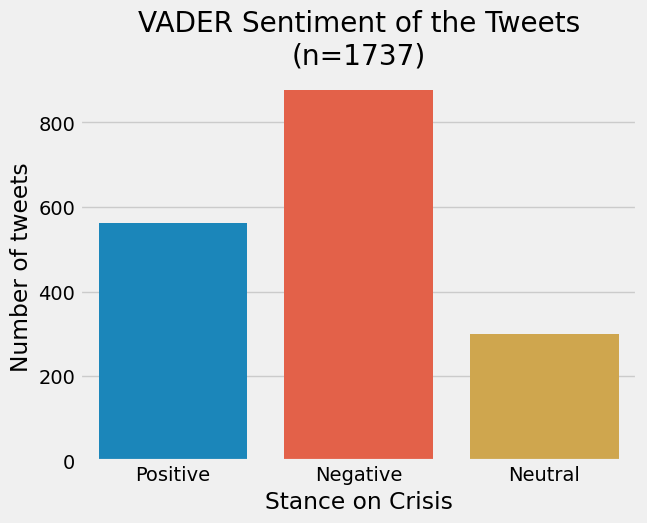

In [28]:
# Sentiment barplot
pos = ["Positive", "Negative", "Neutral"]
cs = {}
# sns.barplot(data=)
for p in pos:
    cs[p] = [np.sum(tweets_df_emb["sentiment"] == p)]
cum_sums = pd.DataFrame(cs)
sns.barplot(data=cum_sums)
print(cum_sums)
plt.xlabel("Stance on Crisis")
plt.ylabel("Number of tweets")
plt.title("VADER Sentiment of the Tweets\n(n=1737)")

In [29]:
# SSE
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(tweets_df_emb.iloc[:,5:])
    inertias.append(kmeans.inertia_)
inertias
# tweets_df_emb.iloc[:, 4]

[1192.119118229918,
 1144.645975229833,
 1117.0838381789083,
 1094.80114794219,
 1077.963718009407,
 1064.1860089074528,
 1053.7891027284397,
 1045.2662537470585,
 1037.4423926650793,
 1031.3599397498467]

Text(0, 0.5, 'SSE')

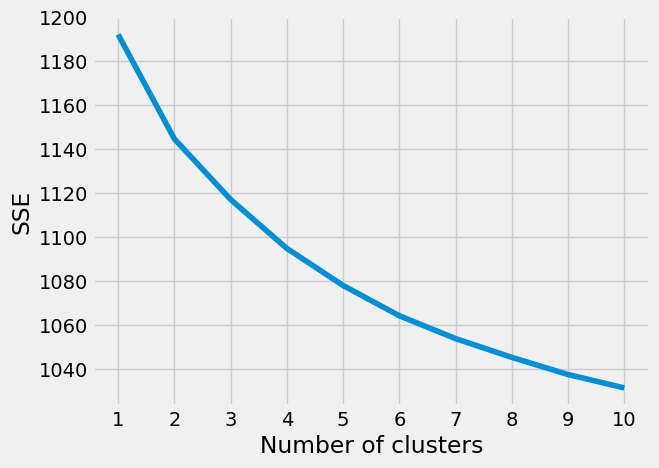

In [30]:
# Elbow plot
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), inertias)
plt.xticks(range(1, 11))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")

In [31]:
# K-means labels
from kneed import KneeLocator
kl = KneeLocator(range(1, 11), inertias, curve="convex", direction="decreasing")
clusters_n = kl.elbow
kmeans = KMeans(n_clusters=kl.elbow, random_state=0)
kmeans.fit(tweets_df_emb.iloc[:,5:])
tweets_df_emb["cluster"] = kmeans.labels_

In [32]:
# Write to file
topics = {0: [], 1: [], 2: [], 3: []}
for i in range(len(kmeans.labels_)):
    topics[kmeans.labels_[i]].append(tweets_df_emb.iloc[i,2])

for n in topics.keys():
    f = open(str(n) + ".txt", "w")
    for tweet in topics[n]:
        f.write("="*10 + "\n")
        f.write(tweet + "\n")
    f.close()

Text(0.5, 1.0, 'K-means Clustering when k=4')

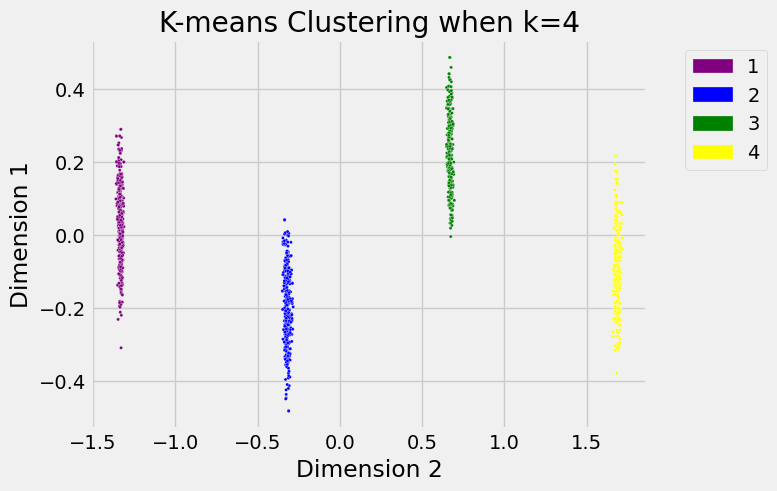

In [33]:
# Dimension reductionality + graph
pca = PCA(n_components=2)
components = pca.fit_transform(tweets_df_emb.iloc[:,6:])
one = mpatches.Patch(color="purple", label="1")
two = mpatches.Patch(color="blue", label="2")
three = mpatches.Patch(color="green", label="3")
four = mpatches.Patch(color="yellow", label="4")
d = {0: "purple", 1: "blue", 2: "green", 3: "yellow"}
sns.scatterplot(x=components[:,0], y=components[:,1], c=[d[l] for l in kmeans.labels_], s=5)
plt.legend(handles=[one, two, three, four], loc="upper left", bbox_to_anchor=(1.05, 1.0))
plt.xlabel("Dimension 2")
plt.ylabel("Dimension 1")
plt.title("K-means Clustering when k=4")

Text(0.5, 1.0, 'Stance of the Tweets')

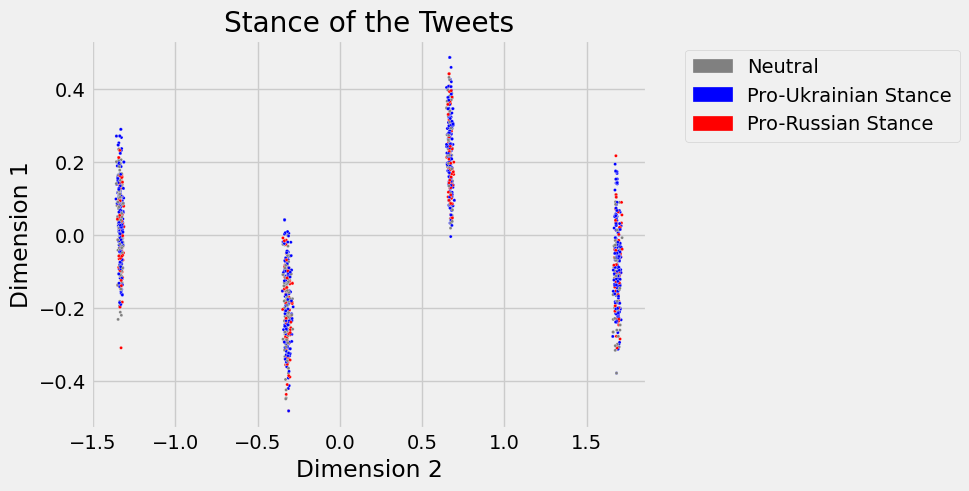

In [34]:
# Stance graph
plt.xlabel("Dimension 2")
plt.ylabel("Dimension 1")
neut = mpatches.Patch(color='grey', label='Neutral')
ukra = mpatches.Patch(color='blue', label='Pro-Ukrainian Stance')
russ = mpatches.Patch(color='red', label='Pro-Russian Stance')
d = {"Neutral": "grey", "ProUkraine": "blue", "ProRussia": "red", "Irrelevant": "black"}
sns.scatterplot(x=components[:,0], y=components[:,1], c=[d[s] for s in tweets_df_emb.iloc[:, 3]], s=5)
plt.legend(handles=[neut, ukra, russ], loc="upper left", bbox_to_anchor=(1.05, 1.0))
plt.xlabel("Dimension 2")
plt.ylabel("Dimension 1")
plt.title("Stance of the Tweets")
#for i in range(tweets_df_emb.shape[0]):
#    plt.annotate(str(tweets_df_emb.iloc[i, 3]), xy=(components[i,0], components[i,1]))

Text(0.5, 1.0, 'Sentiment of the Tweets')

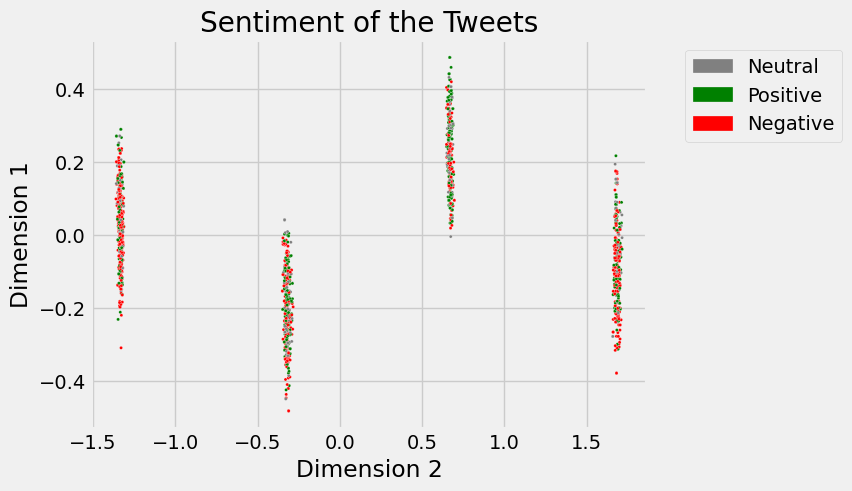

In [35]:
# Sentiment graph
d = {"Neutral": "grey", "Positive": "green", "Negative": "red"}
neut = mpatches.Patch(color='grey', label='Neutral')
pos = mpatches.Patch(color='green', label='Positive')
neg = mpatches.Patch(color='red', label='Negative')
sns.scatterplot(x=components[:,0], y=components[:,1], c=[d[s] for s in tweets_df_emb.iloc[:,4]], s=5)
plt.legend(handles=[neut, pos, neg], loc="upper left", bbox_to_anchor=(1.05, 1.0))
plt.xlabel("Dimension 2")
plt.ylabel("Dimension 1")
plt.title("Sentiment of the Tweets")

In [36]:
# adapted from https://www.kaggle.com/code/ragnisah/text-data-cleaning-tweets-analysis/notebook

# NLP preprocessing
stopwords = nltk.corpus.stopwords.words('english')
snowball = nltk.SnowballStemmer(language='english')
lemma = nltk.WordNetLemmatizer()

def remove_punct(s):
    s = "".join([c for c in s if c not in string.punctuation])
    s = re.sub('[0-9]+', '', s)
    return s

def tokenization(s):
    s = re.split('\W+', s)
    return s

def remove_stopwords(s):
    s = [w for w in s if w not in stopwords]
    return s

def stemming(s):
    s = [snowball.stem(w) for w in s]
    return s

def lemmatizer(s):
    s = [lemma.lemmatize(w) for w in s]
    return s

def remove_tco(s):
    s = [w for w in s if "httpstco" not in w or w != '']
    return s

tweets_df_emb["punct"] = tweets_df_emb["full_text"].apply(lambda x: remove_punct(x))
tweets_df_emb["tokenized"] = tweets_df_emb["punct"].apply(lambda x: tokenization(str.lower(x)))
tweets_df_emb["nonstop"] = tweets_df_emb["tokenized"].apply(lambda x: remove_stopwords(x))
tweets_df_emb["stem"] = tweets_df_emb["nonstop"].apply(lambda x: stemming(x))
tweets_df_emb["final"] = tweets_df_emb["stem"].apply(lambda x: remove_tco(x))
#tweets_df_emb["lemma"] = tweets_df_emb["nonstop"].apply(lambda x: lemmatizer(x))
#tweets_df_emb["final"] = tweets_df_emb["lemma"].apply(lambda x: remove_tco(x))


In [37]:
# Calc counter
clusters = [Counter() for _ in range(clusters_n)]
for i, _ in enumerate(clusters):
    for j in range(tweets_df_emb.shape[0]):
        if tweets_df_emb["cluster"][j] == i:
            clusters[i].update(tweets_df_emb["final"][j])

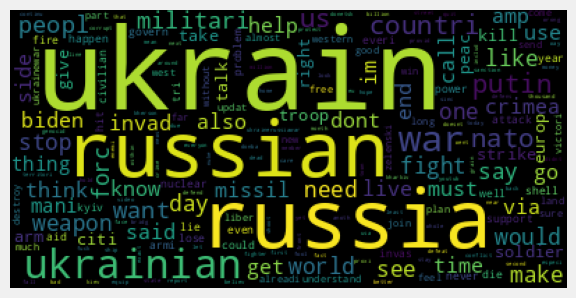

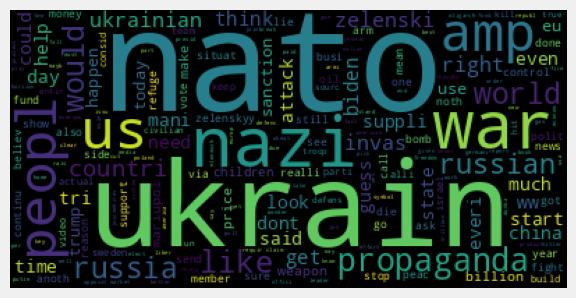

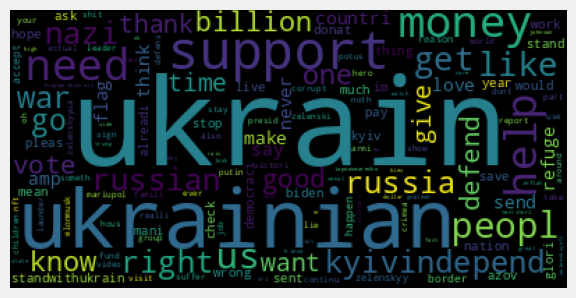

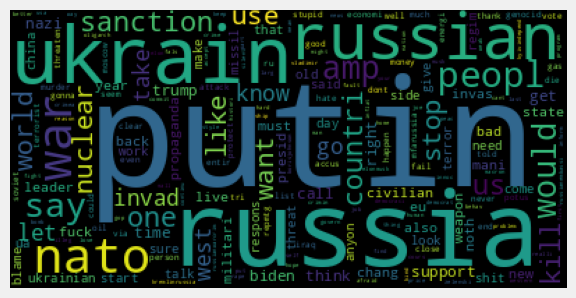

In [38]:
# Draw wordclouds
for cluster in clusters:
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=cluster)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [39]:
# Calculate correctness of tweets stance vs sentiment
def correct(t):
    if (t["Stance Label"] == "ProUkraine" and t["sentiment"] == "Negative") or (t["Stance Label"] == "ProRussia" and t["sentiment"] == "Positive") or (t["Stance Label"] == "Neutral" and t["sentiment"] == "Neutral"):
        return True
    return False
tweets_df_emb["correct"] = tweets_df_emb[["Stance Label", "sentiment"]].apply(correct, axis=1)
np.sum(tweets_df_emb["correct"])/tweets_df_emb.shape[0]

0.3540587219343696